# Modeling

## Contents
[Models and Hyperparameters](##Models and Hyperparameters)

[Evaluation](##Evaluation)

[Analyzing Results](##Analyzing Results)

[Conclusions](##Results)

In [118]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.tree import plot_tree
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import display, Image
import re
import pydotplus

In [48]:
# Suppress warnings
warnings.filterwarnings("ignore")

In [49]:
# Load the dataset
file_path = 'data/processed/uhi.csv'
uhi_data = pd.read_csv(file_path)

In [50]:
# Convert the 'date' column to datetime format
uhi_data['date'] = pd.to_datetime(uhi_data['date'])

# Replace inf values with NaN
uhi_data = uhi_data.replace([np.inf, -np.inf], np.nan)

In [51]:
# Encode categorical variables
label_encoder = LabelEncoder()
uhi_data['city'] = label_encoder.fit_transform(uhi_data['city'])
uhi_data['uhi_observed'] = label_encoder.fit_transform(uhi_data['uhi_observed'])

In [52]:
# Select features and target
X = uhi_data.drop(columns=['uhi_observed', 'date', 'zipcode'])
y = uhi_data['uhi_observed']

In [53]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Models and Hyperparameters

In [55]:
# Define models and hyperparameters for GridSearchCV
models = {
    'RandomForest': RandomForestClassifier(),
    'SVC': SVC(),
    'KNeighbors': KNeighborsClassifier()
}

In [56]:
param_grid = {
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True, False]
    },
    'SVC': {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'gamma': ['scale', 'auto', 0.01, 0.001, 0.0001],
        'class_weight': [None, 'balanced']
    },
    'KNeighbors': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }
}

In [57]:
# Perform GridSearchCV for each model
best_estimators = {}
for model_name in models:
    print(f"\nPerforming GridSearchCV for {model_name}...")
    grid_search = GridSearchCV(models[model_name], param_grid[model_name], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_estimators[model_name] = grid_search.best_estimator_
    print(f"Best Parameters for {model_name}: {grid_search.best_params_}")


Performing GridSearchCV for RandomForest...
Best Parameters for RandomForest: {'bootstrap': True, 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Performing GridSearchCV for SVC...
Best Parameters for SVC: {'C': 100, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}

Performing GridSearchCV for KNeighbors...
Best Parameters for KNeighbors: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}


## Evaluation

In [58]:
# Cross-validation and evaluation
for model_name, model in best_estimators.items():
    print(f"\nCross-validation results for {model_name}...")
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"Mean CV Accuracy for {model_name}: {scores.mean():.2f}")

    # Fit the model on training data and evaluate on test data
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, y_pred))

    # Final Evaluation Step
    print(f"\nFinal Evaluation for {model_name} on Test Data:")
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    print("Confusion Matrix:")
    print(conf_matrix)


Cross-validation results for RandomForest...
Mean CV Accuracy for RandomForest: 0.90

Classification Report for RandomForest:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      5788
           1       0.89      0.89      0.89      4295

    accuracy                           0.91     10083
   macro avg       0.90      0.90      0.90     10083
weighted avg       0.91      0.91      0.91     10083


Final Evaluation for RandomForest on Test Data:
Accuracy: 0.91
Confusion Matrix:
[[5338  450]
 [ 492 3803]]

Cross-validation results for SVC...
Mean CV Accuracy for SVC: 0.84

Classification Report for SVC:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      5788
           1       0.84      0.80      0.82      4295

    accuracy                           0.85     10083
   macro avg       0.85      0.84      0.84     10083
weighted avg       0.85      0.85      0.85     10083


Final Eva

RandomForest is the best-performing model with the highest accuracy (0.91) and balanced precision and recall across both classes. The model benefits from its ability to handle a variety of features and manage the complexity of the dataset. SVC and KNeighbors are slightly less accurate, with accuracies of 0.85 and 0.83 respectively.

## Analyzing Results

### Feature Importances


Feature Importances for RandomForest:
city                                0.183314
avg_lst_c                           0.109207
evergreen_forest_pct                0.104910
day_length_sec                      0.094790
max_air_temp_c                      0.069505
wind_speed_kmh                      0.065592
wind_dir_degrees                    0.057841
shrub_scrub_pct                     0.056961
atm_pressure_hpa                    0.052922
water_vapor_pressure_pa             0.049282
min_air_temp_c                      0.048510
developed_open_space_pct            0.018179
deciduous_forest_pct                0.013105
precipitation_mm                    0.012182
developed_low_intensity_pct         0.010745
developed_medium_intensity_pct      0.010210
population_density                  0.008594
percent_impervious                  0.008044
pasture_hay_pct                     0.006844
open_water_pct                      0.004513
barren_land_pct                     0.003208
grassland_herbac

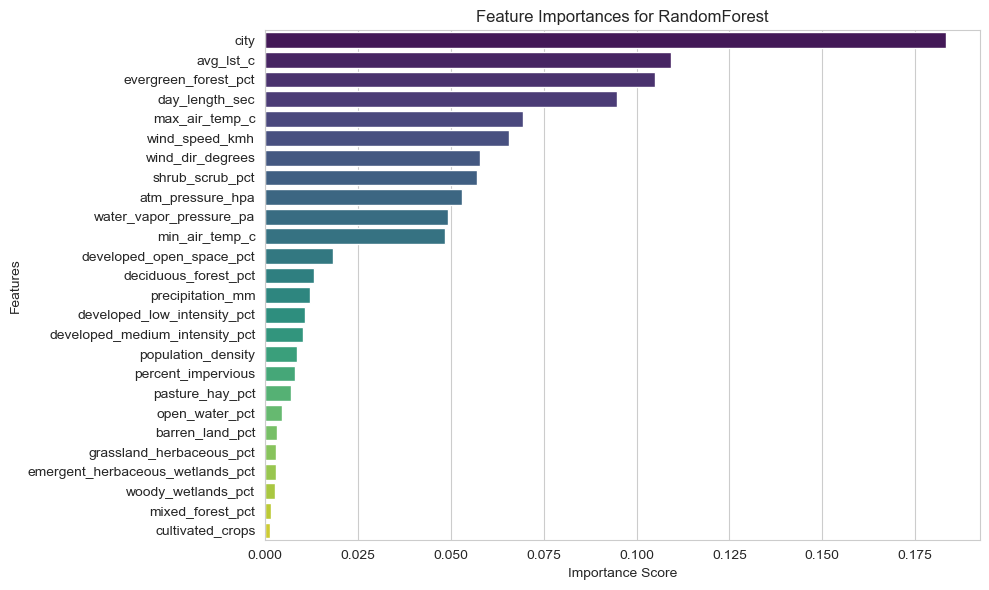

In [132]:
rf_best_model = best_estimators.get('RandomForest')

importances = rf_best_model.feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Print and plot feature importance
print("\nFeature Importances for RandomForest:")
print(feature_importances)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index, palette='viridis')
plt.title('Feature Importances for RandomForest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

Feature Importance Interpretation:

- The feature importance chart shows that city has the highest importance score. This means that the city in which the data is collected plays a major role in predicting the occurrence of urban heat islands.
- The second most important feature is avg_lst_c (Average Land Surface Temperature), which suggests that this variable significantly influences predictions related to urban heat island effects. The land surface temperature is logically correlated to urban heat characteristics, making it highly influential.
- Features like evergreen_forest_pct, day_length_sec, max_air_temp_c, and wind_speed_kmh also contribute significantly, indicating that aspects such as vegetation cover, daily sunlight exposure, temperature, and wind speed are also key factors in determining the urban heat island effect.

### Decision Tree

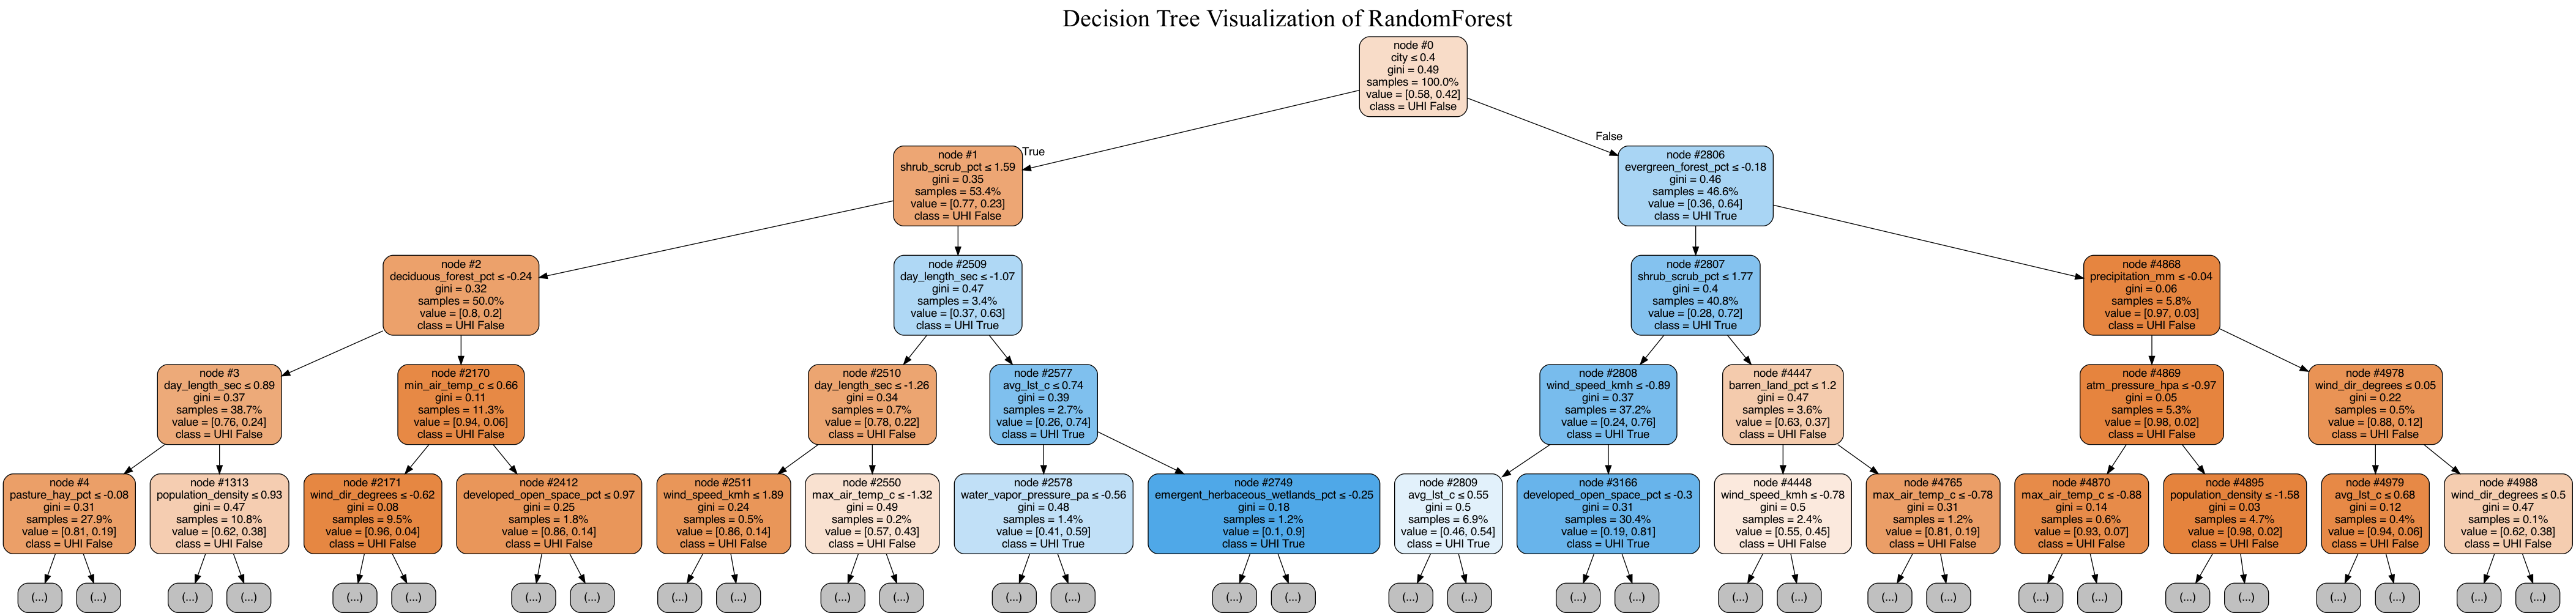

In [133]:
# Visualize one of the decision trees in the RandomForest using Graphviz
class_names = ['UHI False', 'UHI True']

estimator = rf_best_model.estimators_[0]
dot_data = export_graphviz(
    estimator, 
    out_file=None, 
    feature_names=feature_names, 
    filled=True, 
    rounded=True, 
    special_characters=True, 
    max_depth=4, 
    node_ids=True, 
    proportion=True, 
    precision=2, 
    label='all', 
    class_names=class_names)

title = 'Decision Tree Visualization of RandomForest'
lines = dot_data.splitlines()
lines.insert(1, f'graph [label="{title}", labelloc="t", fontsize=30];')

dot_data_with_title = "\n".join(lines)
graph = graphviz.Source(dot_data_with_title)
graph.format = 'png'
graph.render(filename='images/tree_visualization', format='png', cleanup=False)
display(Image(filename='images/tree_visualization.png'))

Decision Tree Interpretation:
1. Root node
The city feature is at the root node, which indicates that the model initially splits the data based on the city. This reflects the significant influence of different cities on the Urban Heat Island (UHI) effect, highlighting that local urbanization characteristics and climate factors vary widely between cities. That aligns with the feature importance ranking.
2. Key features for branching:
    - `shrub_scrub_pct`. This feature represents the percentage of shrub or scrub land cover. It appears early in the tree, indicating that areas with varying degrees of shrub or scrub coverage significantly influence the UHI effect. Shrublands help in cooling, so their percentage can affect the local temperature.
    - `evergreen_forest_pct` and `deciduous_forest_pct`. These features represent the proportion of forest cover. Trees, especially evergreen and deciduous forests, provide shading and cooling through evapotranspiration, which helps mitigate the UHI effect. Their early presence in the decision path suggests their substantial impact.
    - `day_length_sec`. This feature is associated with the length of the day, which impacts the amount of solar radiation absorbed by the land. Longer day lengths can lead to higher temperatures, making this feature important for predicting UHI effects.
    - `avg_lst_c` and `max_air_temp_c`. These features represent the average land surface temperature and the maximum air temperature, respectively. Their appearance in the tree indicates that the temperature metrics are essential to the model's decision-making process, as they directly relate to heat accumulation in urban areas.
3. Other contributing features:
    - `wind_speed_kmh` and `wind_dir_degrees`. Wind can play a role in dispersing heat, affecting the temperature patterns in urban areas. Nodes involving wind speed and direction indicate that airflow characteristics have a role in the UHI effect.
    - `precipitation_mm`. Precipitation affects soil moisture and can contribute to localized cooling, which impacts the UHI effect. The presence of `precipitation_mm` as a decision point reflects its influence on mitigating temperature rises in urban areas.
    - `population_density` and `developed_open_space_pct`. These features represent urbanization metrics such as population density and the proportion of developed open spaces. Higher population density typically correlates with increased building density and impervious surfaces, which trap heat, thereby increasing UHI intensity.

## Conclusions
Urbanization characteristics and specific local climate factors contribute significantly to the Urban Heat Island (UHI) effect in different cities:.

1. **City-Level Influence**: The `city` feature is the most important factor, indicating that UHI effects vary significantly by city. Urban areas have unique characteristics like population density, building materials, and infrastructure that affect heat retention and distribution.

2. **Local Climate Factors**: Features such as `avg_lst_c` (Average Land Surface Temperature), `evergreen_forest_pct`, `day_length_sec`, and `max_air_temp_c` are highly influential in determining UHI. High land surface temperatures, reduced vegetation cover, and increased solar radiation exposure all contribute to elevated heat levels in urban areas.

3. **Vegetation and Land Cover**: The percentage of evergreen and deciduous forest cover, along with other vegetation types (e.g., `shrub_scrub_pct`), plays a crucial role in mitigating UHI effects. Areas with more vegetation tend to have lower UHI effects due to evapotranspiration and shade provided by plants.

4. **Wind and Atmospheric Conditions**: Factors like `wind_speed_kmh`, `wind_dir_degrees`, and `atm_pressure_hpa` also influence UHI intensity. Wind can disperse heat, while atmospheric pressure can affect local weather patterns, influencing temperature distribution.

5. **Built Environment**: Developed land features, such as `developed_open_space_pct` and `percent_impervious`, are also significant, reflecting how the built environment (e.g., buildings, roads) retains and radiates heat, exacerbating UHI.

In summary, urban heat islands are influenced by a combination of urban characteristics (e.g., building density, land use) and local climate factors (e.g., vegetation cover, temperature, wind). The presence of vegetation, local climate conditions, and city-specific infrastructure all contribute to how heat is retained and distributed within urban areas.